In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
f = h5py.File("/content/train_catvnoncat.h5")
train_images = torch.tensor(np.array(f["train_set_x"])).type(torch.float32)
train_labels = torch.tensor(np.array(f["train_set_y"])).type(torch.float32)

f = h5py.File("/content/test_catvnoncat.h5")
test_images = torch.tensor(np.array(f["test_set_x"])).type(torch.float32)
test_labels = torch.tensor(np.array(f["test_set_y"])).type(torch.float32)

In [3]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

torch.Size([209, 64, 64, 3]) torch.Size([209]) torch.Size([50, 64, 64, 3]) torch.Size([50])


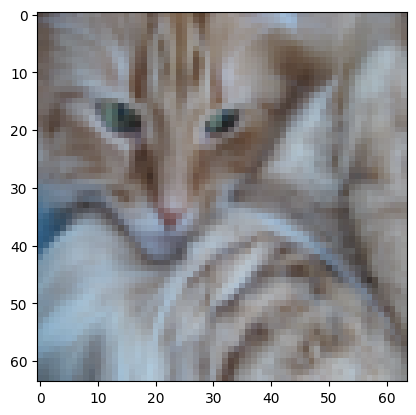

In [4]:
plt.imshow(train_images[2]/255.0) # substitute 2 for other index to see other image
plt.show()

# Model 1: CNN from scratch

In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [6]:
train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=4, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 1)
)

In [8]:
print(model)

Sequential(
  (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(4, 4), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=400, out_features=200, bias=True)
  (11): ReLU()
  (12): Linear(in_features=200, out_features=1, bias=True)
)


In [9]:
print("Number of parameters:", sum([x.numel() for x in model.parameters()]))

Number of parameters: 83181


In [10]:
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def evaluate(model, images, labels):
    with torch.no_grad():
        images, labels = images.cuda(), labels.cuda()
        logits = model(images.permute(0, 3, 1, 2))
        probs = logits.sigmoid()
        preds = (probs > 0.5).float()
        accuracy = (preds.flatten() == labels.flatten()).float().mean().item()
    return accuracy

In [11]:
import tqdm
epochs = 200
training_accuracies, validation_accuracies = [], []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    pbar = tqdm.tqdm(train_loader)
    for i, batch in enumerate(pbar):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        logits = model(images.permute(0, 3, 1, 2))
        loss = F.binary_cross_entropy_with_logits(logits.flatten(), labels.flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.4f}")
    train_accuracy = evaluate(model, train_images, train_labels)
    val_accuracy = evaluate(model, test_images, test_labels)
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)
    print(f"Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f}")

Epoch 1/200


Loss: 0.7222: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 2/200


Loss: 0.6401: 100%|██████████| 7/7 [00:00<00:00, 180.10it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 3/200


Loss: 0.6013: 100%|██████████| 7/7 [00:00<00:00, 187.94it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 4/200


Loss: 0.5275: 100%|██████████| 7/7 [00:00<00:00, 180.29it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 5/200


Loss: 0.4786: 100%|██████████| 7/7 [00:00<00:00, 179.11it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 6/200


Loss: 0.6022: 100%|██████████| 7/7 [00:00<00:00, 188.06it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 7/200


Loss: 0.6908: 100%|██████████| 7/7 [00:00<00:00, 183.38it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 8/200


Loss: 0.5030: 100%|██████████| 7/7 [00:00<00:00, 180.19it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 9/200


Loss: 0.4967: 100%|██████████| 7/7 [00:00<00:00, 181.64it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 10/200


Loss: 0.4425: 100%|██████████| 7/7 [00:00<00:00, 184.97it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 11/200


Loss: 0.4544: 100%|██████████| 7/7 [00:00<00:00, 156.68it/s]


Train Accuracy: 0.656, Val Accuracy: 0.340
Epoch 12/200


Loss: 0.5175: 100%|██████████| 7/7 [00:00<00:00, 151.37it/s]


Train Accuracy: 0.789, Val Accuracy: 0.680
Epoch 13/200


Loss: 0.5385: 100%|██████████| 7/7 [00:00<00:00, 151.29it/s]


Train Accuracy: 0.842, Val Accuracy: 0.760
Epoch 14/200


Loss: 0.4968: 100%|██████████| 7/7 [00:00<00:00, 158.96it/s]


Train Accuracy: 0.809, Val Accuracy: 0.820
Epoch 15/200


Loss: 0.5578: 100%|██████████| 7/7 [00:00<00:00, 170.97it/s]


Train Accuracy: 0.856, Val Accuracy: 0.880
Epoch 16/200


Loss: 0.3683: 100%|██████████| 7/7 [00:00<00:00, 159.66it/s]


Train Accuracy: 0.861, Val Accuracy: 0.780
Epoch 17/200


Loss: 0.2333: 100%|██████████| 7/7 [00:00<00:00, 156.23it/s]


Train Accuracy: 0.847, Val Accuracy: 0.880
Epoch 18/200


Loss: 0.3768: 100%|██████████| 7/7 [00:00<00:00, 163.79it/s]


Train Accuracy: 0.861, Val Accuracy: 0.860
Epoch 19/200


Loss: 0.3077: 100%|██████████| 7/7 [00:00<00:00, 148.33it/s]


Train Accuracy: 0.871, Val Accuracy: 0.860
Epoch 20/200


Loss: 0.2958: 100%|██████████| 7/7 [00:00<00:00, 141.22it/s]


Train Accuracy: 0.871, Val Accuracy: 0.800
Epoch 21/200


Loss: 0.4126: 100%|██████████| 7/7 [00:00<00:00, 163.92it/s]


Train Accuracy: 0.861, Val Accuracy: 0.860
Epoch 22/200


Loss: 0.1296: 100%|██████████| 7/7 [00:00<00:00, 155.31it/s]


Train Accuracy: 0.866, Val Accuracy: 0.640
Epoch 23/200


Loss: 0.2975: 100%|██████████| 7/7 [00:00<00:00, 109.34it/s]


Train Accuracy: 0.823, Val Accuracy: 0.740
Epoch 24/200


Loss: 0.4480: 100%|██████████| 7/7 [00:00<00:00, 97.46it/s]


Train Accuracy: 0.914, Val Accuracy: 0.820
Epoch 25/200


Loss: 0.2214: 100%|██████████| 7/7 [00:00<00:00, 63.29it/s]


Train Accuracy: 0.923, Val Accuracy: 0.820
Epoch 26/200


Loss: 0.1870: 100%|██████████| 7/7 [00:00<00:00, 94.93it/s]


Train Accuracy: 0.914, Val Accuracy: 0.880
Epoch 27/200


Loss: 0.2332: 100%|██████████| 7/7 [00:00<00:00, 89.35it/s]


Train Accuracy: 0.914, Val Accuracy: 0.800
Epoch 28/200


Loss: 0.1444: 100%|██████████| 7/7 [00:00<00:00, 57.12it/s]


Train Accuracy: 0.928, Val Accuracy: 0.880
Epoch 29/200


Loss: 0.1627: 100%|██████████| 7/7 [00:00<00:00, 84.07it/s]


Train Accuracy: 0.880, Val Accuracy: 0.780
Epoch 30/200


Loss: 0.1519: 100%|██████████| 7/7 [00:00<00:00, 57.66it/s]


Train Accuracy: 0.813, Val Accuracy: 0.680
Epoch 31/200


Loss: 0.1581: 100%|██████████| 7/7 [00:00<00:00, 102.23it/s]


Train Accuracy: 0.818, Val Accuracy: 0.840
Epoch 32/200


Loss: 0.3274: 100%|██████████| 7/7 [00:00<00:00, 84.50it/s]


Train Accuracy: 0.837, Val Accuracy: 0.880
Epoch 33/200


Loss: 0.1476: 100%|██████████| 7/7 [00:00<00:00, 63.95it/s]


Train Accuracy: 0.923, Val Accuracy: 0.820
Epoch 34/200


Loss: 0.2260: 100%|██████████| 7/7 [00:00<00:00, 57.24it/s]


Train Accuracy: 0.885, Val Accuracy: 0.820
Epoch 35/200


Loss: 0.2319: 100%|██████████| 7/7 [00:00<00:00, 141.51it/s]


Train Accuracy: 0.909, Val Accuracy: 0.820
Epoch 36/200


Loss: 0.2236: 100%|██████████| 7/7 [00:00<00:00, 174.02it/s]


Train Accuracy: 0.909, Val Accuracy: 0.840
Epoch 37/200


Loss: 0.0923: 100%|██████████| 7/7 [00:00<00:00, 162.63it/s]


Train Accuracy: 0.928, Val Accuracy: 0.840
Epoch 38/200


Loss: 0.0536: 100%|██████████| 7/7 [00:00<00:00, 151.41it/s]


Train Accuracy: 0.938, Val Accuracy: 0.880
Epoch 39/200


Loss: 0.1509: 100%|██████████| 7/7 [00:00<00:00, 151.78it/s]


Train Accuracy: 0.947, Val Accuracy: 0.800
Epoch 40/200


Loss: 0.3321: 100%|██████████| 7/7 [00:00<00:00, 151.68it/s]


Train Accuracy: 0.938, Val Accuracy: 0.860
Epoch 41/200


Loss: 0.3806: 100%|██████████| 7/7 [00:00<00:00, 162.53it/s]


Train Accuracy: 0.947, Val Accuracy: 0.780
Epoch 42/200


Loss: 0.0913: 100%|██████████| 7/7 [00:00<00:00, 147.27it/s]


Train Accuracy: 0.962, Val Accuracy: 0.860
Epoch 43/200


Loss: 0.1262: 100%|██████████| 7/7 [00:00<00:00, 145.47it/s]


Train Accuracy: 0.947, Val Accuracy: 0.880
Epoch 44/200


Loss: 0.0971: 100%|██████████| 7/7 [00:00<00:00, 122.44it/s]


Train Accuracy: 0.957, Val Accuracy: 0.880
Epoch 45/200


Loss: 0.2476: 100%|██████████| 7/7 [00:00<00:00, 146.62it/s]


Train Accuracy: 0.957, Val Accuracy: 0.800
Epoch 46/200


Loss: 0.2641: 100%|██████████| 7/7 [00:00<00:00, 148.31it/s]


Train Accuracy: 0.885, Val Accuracy: 0.800
Epoch 47/200


Loss: 0.2412: 100%|██████████| 7/7 [00:00<00:00, 146.06it/s]


Train Accuracy: 0.938, Val Accuracy: 0.800
Epoch 48/200


Loss: 0.0775: 100%|██████████| 7/7 [00:00<00:00, 141.11it/s]


Train Accuracy: 0.967, Val Accuracy: 0.820
Epoch 49/200


Loss: 0.1915: 100%|██████████| 7/7 [00:00<00:00, 187.89it/s]


Train Accuracy: 0.947, Val Accuracy: 0.840
Epoch 50/200


Loss: 0.0685: 100%|██████████| 7/7 [00:00<00:00, 181.41it/s]


Train Accuracy: 0.871, Val Accuracy: 0.820
Epoch 51/200


Loss: 0.0539: 100%|██████████| 7/7 [00:00<00:00, 161.80it/s]


Train Accuracy: 0.938, Val Accuracy: 0.840
Epoch 52/200


Loss: 0.1839: 100%|██████████| 7/7 [00:00<00:00, 180.45it/s]

Train Accuracy: 0.928, Val Accuracy: 0.820


Epoch 53/200


Loss: 0.1388: 100%|██████████| 7/7 [00:00<00:00, 165.25it/s]


Train Accuracy: 0.952, Val Accuracy: 0.860
Epoch 54/200


Loss: 0.1618: 100%|██████████| 7/7 [00:00<00:00, 181.71it/s]


Train Accuracy: 0.967, Val Accuracy: 0.820
Epoch 55/200


Loss: 0.2076: 100%|██████████| 7/7 [00:00<00:00, 187.21it/s]


Train Accuracy: 0.967, Val Accuracy: 0.860
Epoch 56/200


Loss: 0.1695: 100%|██████████| 7/7 [00:00<00:00, 181.28it/s]


Train Accuracy: 0.971, Val Accuracy: 0.860
Epoch 57/200


Loss: 0.0674: 100%|██████████| 7/7 [00:00<00:00, 181.29it/s]


Train Accuracy: 0.981, Val Accuracy: 0.880
Epoch 58/200


Loss: 0.2539: 100%|██████████| 7/7 [00:00<00:00, 192.54it/s]


Train Accuracy: 0.986, Val Accuracy: 0.860
Epoch 59/200


Loss: 0.0174: 100%|██████████| 7/7 [00:00<00:00, 184.41it/s]


Train Accuracy: 0.981, Val Accuracy: 0.860
Epoch 60/200


Loss: 0.0505: 100%|██████████| 7/7 [00:00<00:00, 213.31it/s]


Train Accuracy: 0.986, Val Accuracy: 0.860
Epoch 61/200


Loss: 0.1666: 100%|██████████| 7/7 [00:00<00:00, 192.85it/s]


Train Accuracy: 0.976, Val Accuracy: 0.860
Epoch 62/200


Loss: 0.0415: 100%|██████████| 7/7 [00:00<00:00, 192.64it/s]


Train Accuracy: 0.990, Val Accuracy: 0.860
Epoch 63/200


Loss: 0.1776: 100%|██████████| 7/7 [00:00<00:00, 184.44it/s]


Train Accuracy: 0.967, Val Accuracy: 0.840
Epoch 64/200


Loss: 0.1172: 100%|██████████| 7/7 [00:00<00:00, 184.05it/s]


Train Accuracy: 0.971, Val Accuracy: 0.860
Epoch 65/200


Loss: 0.0503: 100%|██████████| 7/7 [00:00<00:00, 167.97it/s]


Train Accuracy: 0.995, Val Accuracy: 0.840
Epoch 66/200


Loss: 0.0565: 100%|██████████| 7/7 [00:00<00:00, 158.59it/s]


Train Accuracy: 0.976, Val Accuracy: 0.860
Epoch 67/200


Loss: 0.0744: 100%|██████████| 7/7 [00:00<00:00, 170.85it/s]


Train Accuracy: 0.986, Val Accuracy: 0.860
Epoch 68/200


Loss: 0.0263: 100%|██████████| 7/7 [00:00<00:00, 182.43it/s]


Train Accuracy: 0.990, Val Accuracy: 0.860
Epoch 69/200


Loss: 0.1010: 100%|██████████| 7/7 [00:00<00:00, 179.44it/s]


Train Accuracy: 0.990, Val Accuracy: 0.860
Epoch 70/200


Loss: 0.0194: 100%|██████████| 7/7 [00:00<00:00, 185.62it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 71/200


Loss: 0.0192: 100%|██████████| 7/7 [00:00<00:00, 163.77it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 72/200


Loss: 0.0143: 100%|██████████| 7/7 [00:00<00:00, 185.64it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 73/200


Loss: 0.0543: 100%|██████████| 7/7 [00:00<00:00, 184.47it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 74/200


Loss: 0.0324: 100%|██████████| 7/7 [00:00<00:00, 182.75it/s]


Train Accuracy: 0.986, Val Accuracy: 0.860
Epoch 75/200


Loss: 0.0352: 100%|██████████| 7/7 [00:00<00:00, 161.21it/s]


Train Accuracy: 0.986, Val Accuracy: 0.840
Epoch 76/200


Loss: 0.0718: 100%|██████████| 7/7 [00:00<00:00, 181.85it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 77/200


Loss: 0.0548: 100%|██████████| 7/7 [00:00<00:00, 175.62it/s]


Train Accuracy: 0.986, Val Accuracy: 0.860
Epoch 78/200


Loss: 0.0466: 100%|██████████| 7/7 [00:00<00:00, 190.98it/s]

Train Accuracy: 0.995, Val Accuracy: 0.860


Epoch 79/200


Loss: 0.0132: 100%|██████████| 7/7 [00:00<00:00, 197.49it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 80/200


Loss: 0.0296: 100%|██████████| 7/7 [00:00<00:00, 193.18it/s]


Train Accuracy: 0.990, Val Accuracy: 0.860
Epoch 81/200


Loss: 0.0357: 100%|██████████| 7/7 [00:00<00:00, 169.25it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 82/200


Loss: 0.0027: 100%|██████████| 7/7 [00:00<00:00, 77.91it/s]


Train Accuracy: 0.990, Val Accuracy: 0.860
Epoch 83/200


Loss: 0.0115: 100%|██████████| 7/7 [00:00<00:00, 106.66it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 84/200


Loss: 0.1191: 100%|██████████| 7/7 [00:00<00:00, 100.00it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 85/200


Loss: 0.0187: 100%|██████████| 7/7 [00:00<00:00, 109.78it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 86/200


Loss: 0.0123: 100%|██████████| 7/7 [00:00<00:00, 118.08it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 87/200


Loss: 0.0034: 100%|██████████| 7/7 [00:00<00:00, 135.60it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 88/200


Loss: 0.0042: 100%|██████████| 7/7 [00:00<00:00, 84.34it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 89/200


Loss: 0.0391: 100%|██████████| 7/7 [00:00<00:00, 105.69it/s]


Train Accuracy: 1.000, Val Accuracy: 0.840
Epoch 90/200


Loss: 0.0461: 100%|██████████| 7/7 [00:00<00:00, 137.06it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 91/200


Loss: 0.0091: 100%|██████████| 7/7 [00:00<00:00, 108.88it/s]


Train Accuracy: 0.947, Val Accuracy: 0.780
Epoch 92/200


Loss: 0.0297: 100%|██████████| 7/7 [00:00<00:00, 132.63it/s]


Train Accuracy: 0.990, Val Accuracy: 0.860
Epoch 93/200


Loss: 0.0691: 100%|██████████| 7/7 [00:00<00:00, 147.50it/s]


Train Accuracy: 0.976, Val Accuracy: 0.840
Epoch 94/200


Loss: 0.0909: 100%|██████████| 7/7 [00:00<00:00, 61.70it/s]


Train Accuracy: 0.990, Val Accuracy: 0.760
Epoch 95/200


Loss: 0.0161: 100%|██████████| 7/7 [00:00<00:00, 62.36it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 96/200


Loss: 0.0081: 100%|██████████| 7/7 [00:00<00:00, 54.98it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 97/200


Loss: 0.0186: 100%|██████████| 7/7 [00:00<00:00, 104.49it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 98/200


Loss: 0.0316: 100%|██████████| 7/7 [00:00<00:00, 62.44it/s]


Train Accuracy: 0.995, Val Accuracy: 0.860
Epoch 99/200


Loss: 0.0078: 100%|██████████| 7/7 [00:00<00:00, 93.60it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 100/200


Loss: 0.0046: 100%|██████████| 7/7 [00:00<00:00, 124.02it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 101/200


Loss: 0.0110: 100%|██████████| 7/7 [00:00<00:00, 113.68it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 102/200


Loss: 0.0118: 100%|██████████| 7/7 [00:00<00:00, 125.73it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 103/200


Loss: 0.0235: 100%|██████████| 7/7 [00:00<00:00, 109.61it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 104/200


Loss: 0.0016: 100%|██████████| 7/7 [00:00<00:00, 124.08it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 105/200


Loss: 0.0097: 100%|██████████| 7/7 [00:00<00:00, 126.68it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 106/200


Loss: 0.0015: 100%|██████████| 7/7 [00:00<00:00, 131.68it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 107/200


Loss: 0.0069: 100%|██████████| 7/7 [00:00<00:00, 117.41it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 108/200


Loss: 0.0048: 100%|██████████| 7/7 [00:00<00:00, 97.52it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 109/200


Loss: 0.0014: 100%|██████████| 7/7 [00:00<00:00, 126.62it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 110/200


Loss: 0.0075: 100%|██████████| 7/7 [00:00<00:00, 142.43it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 111/200


Loss: 0.0051: 100%|██████████| 7/7 [00:00<00:00, 110.85it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 112/200


Loss: 0.0011: 100%|██████████| 7/7 [00:00<00:00, 138.35it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 113/200


Loss: 0.0080: 100%|██████████| 7/7 [00:00<00:00, 117.57it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 114/200


Loss: 0.0019: 100%|██████████| 7/7 [00:00<00:00, 113.13it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 115/200


Loss: 0.0026: 100%|██████████| 7/7 [00:00<00:00, 91.10it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 116/200


Loss: 0.0018: 100%|██████████| 7/7 [00:00<00:00, 112.98it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 117/200


Loss: 0.0015: 100%|██████████| 7/7 [00:00<00:00, 109.43it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 118/200


Loss: 0.0029: 100%|██████████| 7/7 [00:00<00:00, 85.60it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 119/200


Loss: 0.0033: 100%|██████████| 7/7 [00:00<00:00, 105.94it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 120/200


Loss: 0.0021: 100%|██████████| 7/7 [00:00<00:00, 89.42it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 121/200


Loss: 0.0017: 100%|██████████| 7/7 [00:00<00:00, 117.43it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 122/200


Loss: 0.0048: 100%|██████████| 7/7 [00:00<00:00, 115.63it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 123/200


Loss: 0.0012: 100%|██████████| 7/7 [00:00<00:00, 140.23it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 124/200


Loss: 0.0014: 100%|██████████| 7/7 [00:00<00:00, 121.08it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 125/200


Loss: 0.0058: 100%|██████████| 7/7 [00:00<00:00, 122.99it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 126/200


Loss: 0.0047: 100%|██████████| 7/7 [00:00<00:00, 130.24it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 127/200


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00, 116.28it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 128/200


Loss: 0.0037: 100%|██████████| 7/7 [00:00<00:00, 116.00it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 129/200


Loss: 0.0097: 100%|██████████| 7/7 [00:00<00:00, 78.75it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 130/200


Loss: 0.0017: 100%|██████████| 7/7 [00:00<00:00, 72.61it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 131/200


Loss: 0.0004: 100%|██████████| 7/7 [00:00<00:00, 107.27it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 132/200


Loss: 0.0031: 100%|██████████| 7/7 [00:00<00:00, 169.17it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 133/200


Loss: 0.0012: 100%|██████████| 7/7 [00:00<00:00, 150.93it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 134/200


Loss: 0.0009: 100%|██████████| 7/7 [00:00<00:00, 161.35it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 135/200


Loss: 0.0019: 100%|██████████| 7/7 [00:00<00:00, 153.55it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 136/200


Loss: 0.0009: 100%|██████████| 7/7 [00:00<00:00, 173.13it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 137/200


Loss: 0.0011: 100%|██████████| 7/7 [00:00<00:00, 172.60it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 138/200


Loss: 0.0010: 100%|██████████| 7/7 [00:00<00:00, 169.62it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 139/200


Loss: 0.0030: 100%|██████████| 7/7 [00:00<00:00, 182.22it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 140/200


Loss: 0.0009: 100%|██████████| 7/7 [00:00<00:00, 165.80it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 141/200


Loss: 0.0013: 100%|██████████| 7/7 [00:00<00:00, 177.17it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 142/200


Loss: 0.0011: 100%|██████████| 7/7 [00:00<00:00, 166.14it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 143/200


Loss: 0.0013: 100%|██████████| 7/7 [00:00<00:00, 161.60it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 144/200


Loss: 0.0007: 100%|██████████| 7/7 [00:00<00:00, 176.78it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 145/200


Loss: 0.0010: 100%|██████████| 7/7 [00:00<00:00, 167.24it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 146/200


Loss: 0.0013: 100%|██████████| 7/7 [00:00<00:00, 174.81it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 147/200


Loss: 0.0012: 100%|██████████| 7/7 [00:00<00:00, 174.52it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 148/200


Loss: 0.0013: 100%|██████████| 7/7 [00:00<00:00, 180.90it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 149/200


Loss: 0.0045: 100%|██████████| 7/7 [00:00<00:00, 171.75it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 150/200


Loss: 0.0002: 100%|██████████| 7/7 [00:00<00:00, 163.45it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 151/200


Loss: 0.0013: 100%|██████████| 7/7 [00:00<00:00, 170.04it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 152/200


Loss: 0.0024: 100%|██████████| 7/7 [00:00<00:00, 174.06it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 153/200


Loss: 0.0020: 100%|██████████| 7/7 [00:00<00:00, 141.72it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 154/200


Loss: 0.0002: 100%|██████████| 7/7 [00:00<00:00, 154.10it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 155/200


Loss: 0.0005: 100%|██████████| 7/7 [00:00<00:00, 167.44it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 156/200


Loss: 0.0013: 100%|██████████| 7/7 [00:00<00:00, 167.33it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 157/200


Loss: 0.0013: 100%|██████████| 7/7 [00:00<00:00, 167.17it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 158/200


Loss: 0.0004: 100%|██████████| 7/7 [00:00<00:00, 181.79it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 159/200


Loss: 0.0027: 100%|██████████| 7/7 [00:00<00:00, 182.22it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 160/200


Loss: 0.0007: 100%|██████████| 7/7 [00:00<00:00, 168.58it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 161/200


Loss: 0.0005: 100%|██████████| 7/7 [00:00<00:00, 174.38it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 162/200


Loss: 0.0016: 100%|██████████| 7/7 [00:00<00:00, 186.27it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 163/200


Loss: 0.0005: 100%|██████████| 7/7 [00:00<00:00, 182.28it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 164/200


Loss: 0.0007: 100%|██████████| 7/7 [00:00<00:00, 169.33it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 165/200


Loss: 0.0013: 100%|██████████| 7/7 [00:00<00:00, 162.55it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 166/200


Loss: 0.0009: 100%|██████████| 7/7 [00:00<00:00, 166.31it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 167/200


Loss: 0.0006: 100%|██████████| 7/7 [00:00<00:00, 151.86it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 168/200


Loss: 0.0007: 100%|██████████| 7/7 [00:00<00:00, 177.25it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 169/200


Loss: 0.0004: 100%|██████████| 7/7 [00:00<00:00, 161.21it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 170/200


Loss: 0.0012: 100%|██████████| 7/7 [00:00<00:00, 172.88it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 171/200


Loss: 0.0018: 100%|██████████| 7/7 [00:00<00:00, 183.78it/s]

Train Accuracy: 1.000, Val Accuracy: 0.860


Epoch 172/200


Loss: 0.0006: 100%|██████████| 7/7 [00:00<00:00, 175.90it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 173/200


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00, 172.81it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 174/200


Loss: 0.0005: 100%|██████████| 7/7 [00:00<00:00, 134.64it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 175/200


Loss: 0.0008: 100%|██████████| 7/7 [00:00<00:00, 177.83it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 176/200


Loss: 0.0008: 100%|██████████| 7/7 [00:00<00:00, 183.89it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 177/200


Loss: 0.0019: 100%|██████████| 7/7 [00:00<00:00, 181.68it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 178/200


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00, 171.71it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 179/200


Loss: 0.0019: 100%|██████████| 7/7 [00:00<00:00, 160.83it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 180/200


Loss: 0.0006: 100%|██████████| 7/7 [00:00<00:00, 194.42it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 181/200


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00, 168.04it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 182/200


Loss: 0.0001: 100%|██████████| 7/7 [00:00<00:00, 183.29it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 183/200


Loss: 0.0009: 100%|██████████| 7/7 [00:00<00:00, 173.91it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 184/200


Loss: 0.0010: 100%|██████████| 7/7 [00:00<00:00, 167.83it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 185/200


Loss: 0.0009: 100%|██████████| 7/7 [00:00<00:00, 177.41it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 186/200


Loss: 0.0009: 100%|██████████| 7/7 [00:00<00:00, 172.56it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 187/200


Loss: 0.0006: 100%|██████████| 7/7 [00:00<00:00, 161.72it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 188/200


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00, 181.35it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 189/200


Loss: 0.0007: 100%|██████████| 7/7 [00:00<00:00, 168.38it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 190/200


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00, 180.79it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 191/200


Loss: 0.0001: 100%|██████████| 7/7 [00:00<00:00, 190.18it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 192/200


Loss: 0.0005: 100%|██████████| 7/7 [00:00<00:00, 176.43it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 193/200


Loss: 0.0008: 100%|██████████| 7/7 [00:00<00:00, 162.31it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 194/200


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00, 135.76it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 195/200


Loss: 0.0004: 100%|██████████| 7/7 [00:00<00:00, 148.45it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 196/200


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00, 190.47it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 197/200


Loss: 0.0006: 100%|██████████| 7/7 [00:00<00:00, 187.48it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 198/200


Loss: 0.0004: 100%|██████████| 7/7 [00:00<00:00, 172.29it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 199/200


Loss: 0.0004: 100%|██████████| 7/7 [00:00<00:00, 159.84it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860
Epoch 200/200


Loss: 0.0008: 100%|██████████| 7/7 [00:00<00:00, 163.04it/s]


Train Accuracy: 1.000, Val Accuracy: 0.860


If you are in a Colab Notebook, you can try switching the runtime type to a GPU by clicking Runtime -> Change Runtime Type and then selecting GPU as the Hardware Accelerator. This should deliver a pretty big speed-up.

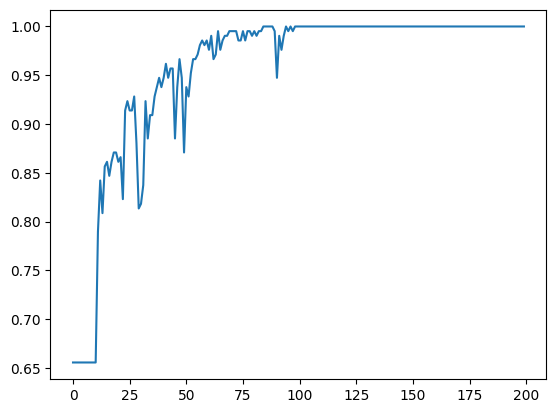

In [12]:
plt.plot(training_accuracies)

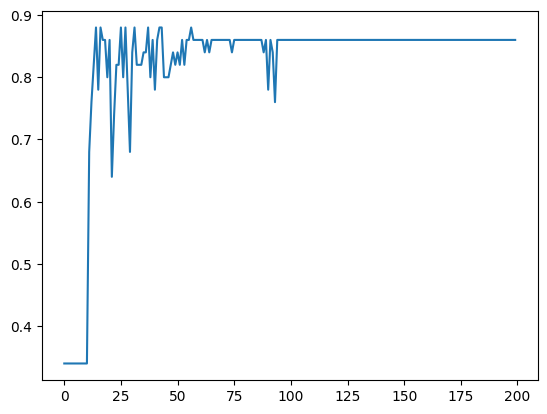

In [13]:
plt.plot(validation_accuracies)

----------------------
Predicted: cat
Actual: cat


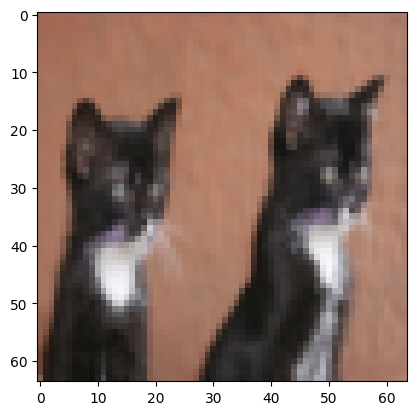

----------------------
----------------------
Predicted: cat
Actual: cat


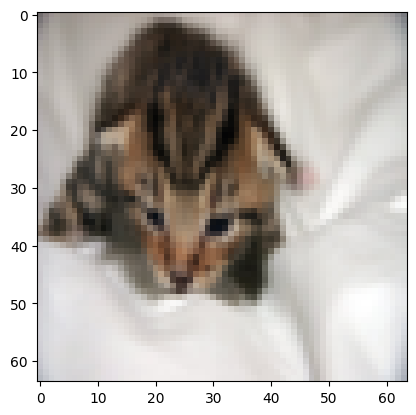

----------------------
----------------------
Predicted: cat
Actual: cat


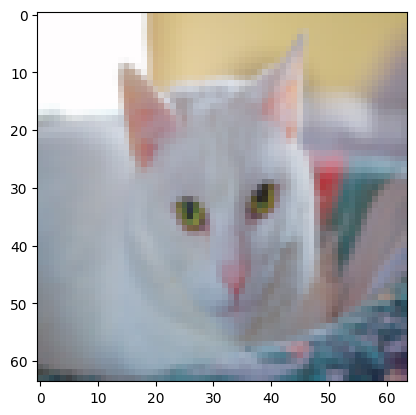

----------------------
----------------------
Predicted: cat
Actual: cat


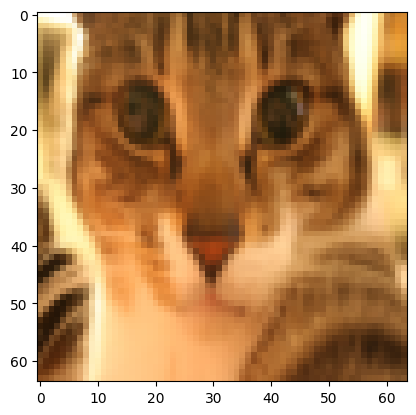

----------------------
----------------------
Predicted: cat
Actual: cat


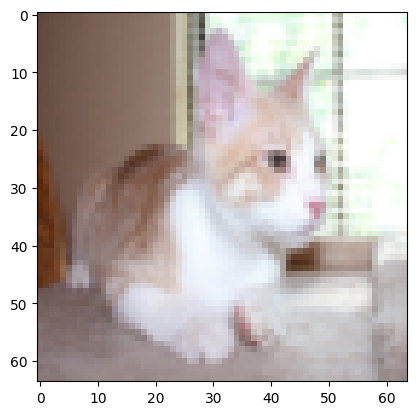

----------------------
----------------------
Predicted: not cat
Actual: not cat


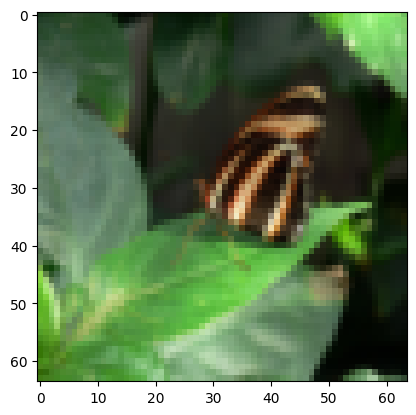

----------------------
----------------------
Predicted: cat
Actual: cat


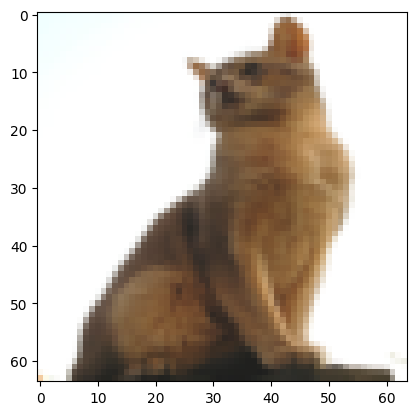

----------------------
----------------------
Predicted: cat
Actual: cat


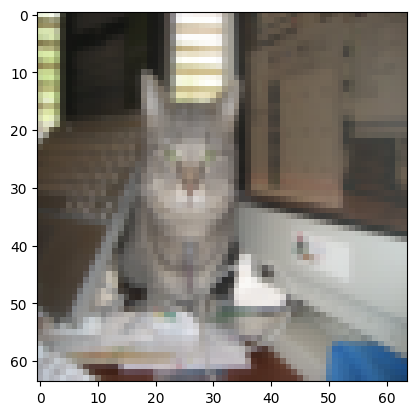

----------------------
----------------------
Predicted: cat
Actual: cat


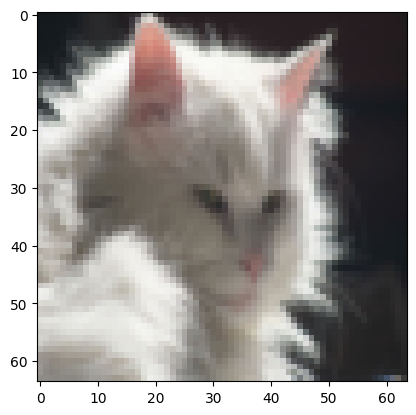

----------------------
----------------------
Predicted: cat
Actual: cat


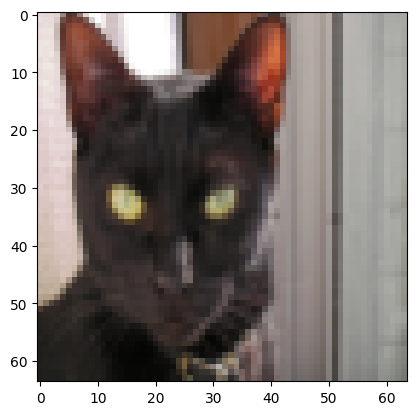

----------------------
----------------------
Predicted: cat
Actual: cat


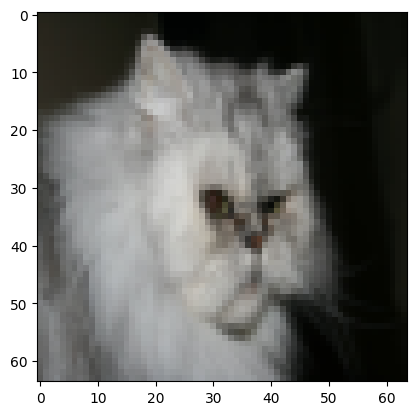

----------------------
----------------------
Predicted: cat
Actual: cat


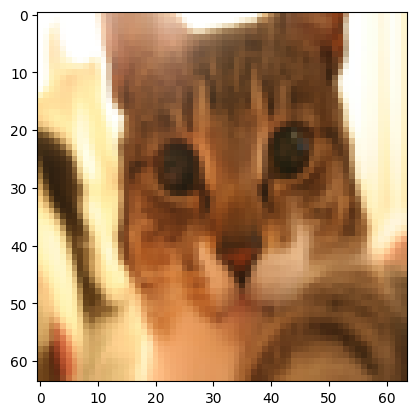

----------------------
----------------------
Predicted: cat
Actual: cat


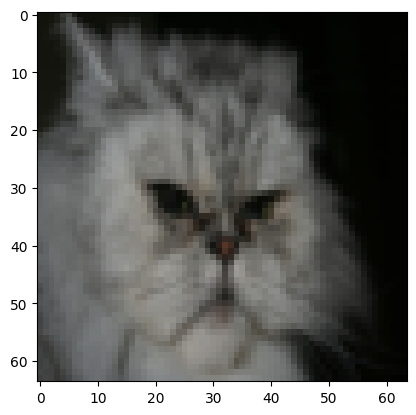

----------------------
----------------------
Predicted: cat
Actual: not cat


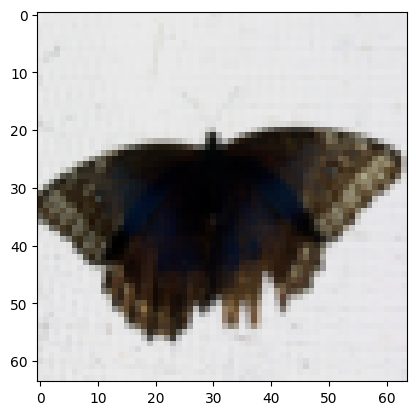

----------------------
----------------------
Predicted: not cat
Actual: not cat


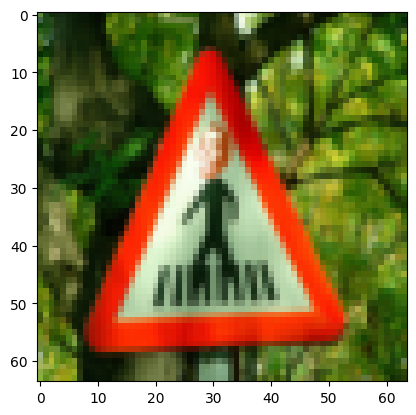

----------------------
----------------------
Predicted: not cat
Actual: cat


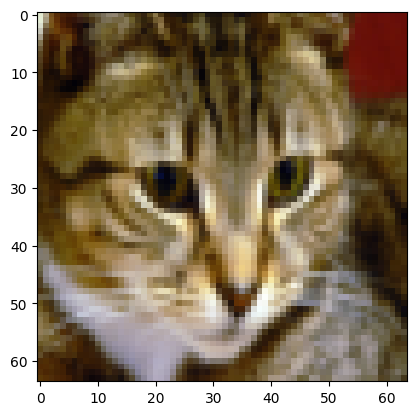

----------------------
----------------------
Predicted: not cat
Actual: not cat


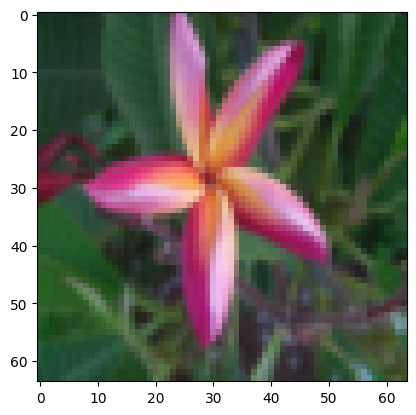

----------------------
----------------------
Predicted: cat
Actual: cat


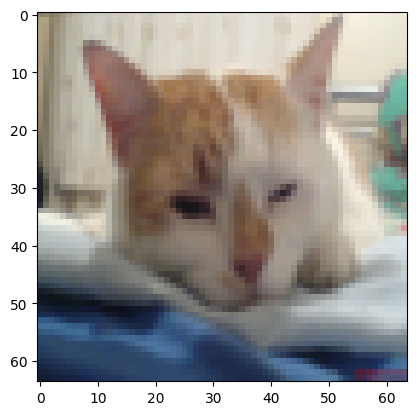

----------------------
----------------------
Predicted: cat
Actual: cat


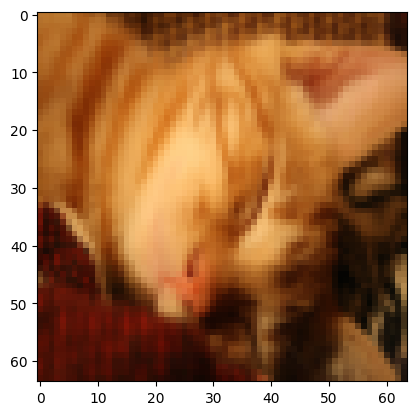

----------------------
----------------------
Predicted: not cat
Actual: cat


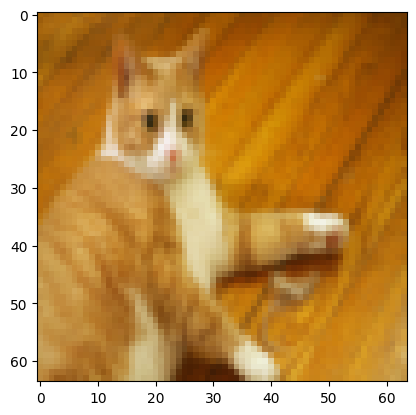

----------------------
----------------------
Predicted: cat
Actual: cat


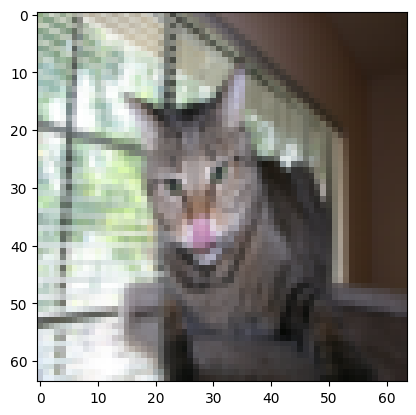

----------------------
----------------------
Predicted: not cat
Actual: not cat


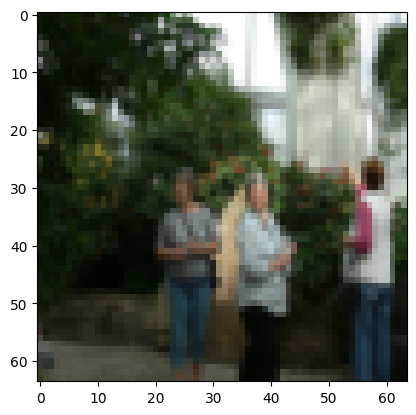

----------------------
----------------------
Predicted: not cat
Actual: not cat


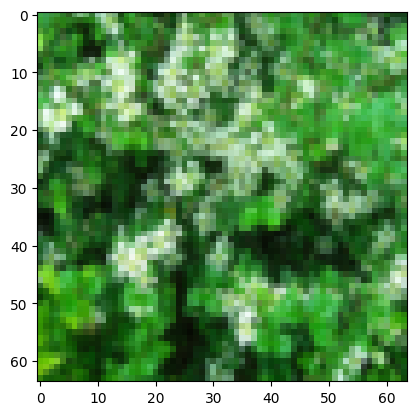

----------------------
----------------------
Predicted: cat
Actual: cat


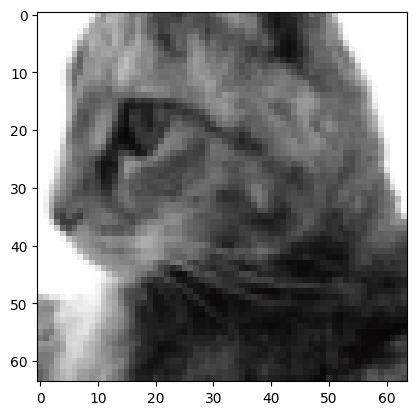

----------------------
----------------------
Predicted: cat
Actual: cat


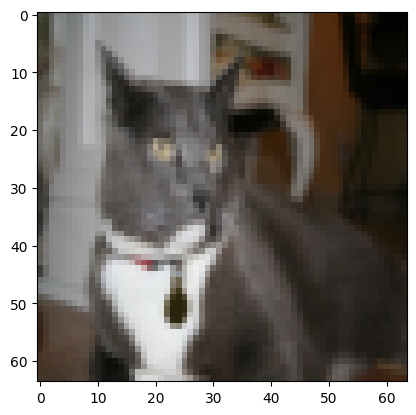

----------------------
----------------------
Predicted: cat
Actual: cat


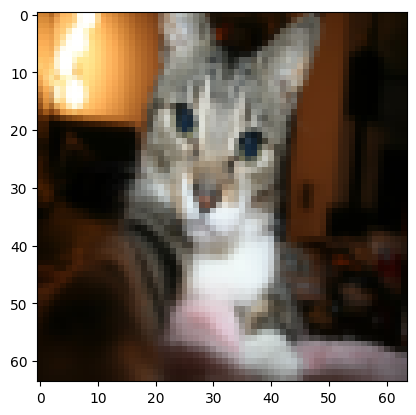

----------------------
----------------------
Predicted: cat
Actual: cat


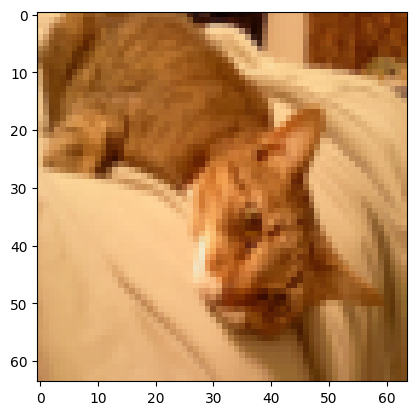

----------------------
----------------------
Predicted: not cat
Actual: not cat


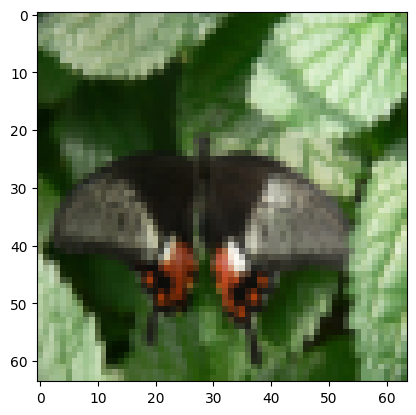

----------------------
----------------------
Predicted: cat
Actual: cat


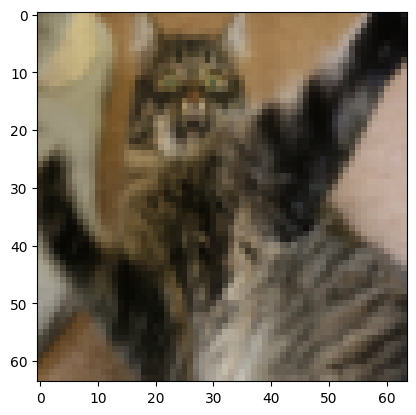

----------------------
----------------------
Predicted: not cat
Actual: not cat


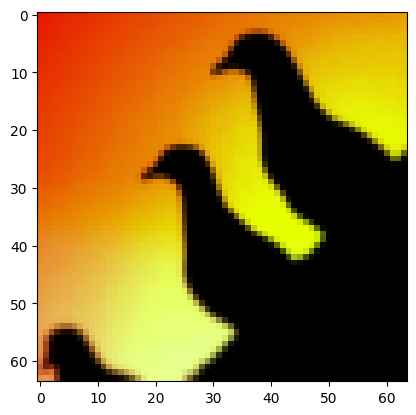

----------------------
----------------------
Predicted: cat
Actual: cat


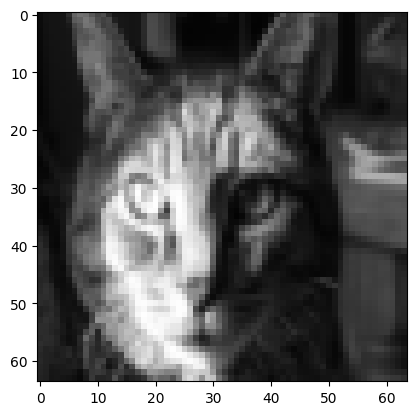

----------------------
----------------------
Predicted: cat
Actual: cat


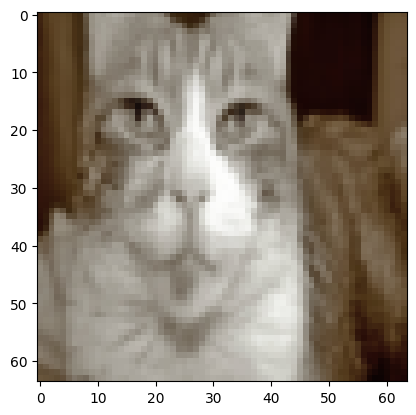

----------------------
----------------------
Predicted: cat
Actual: cat


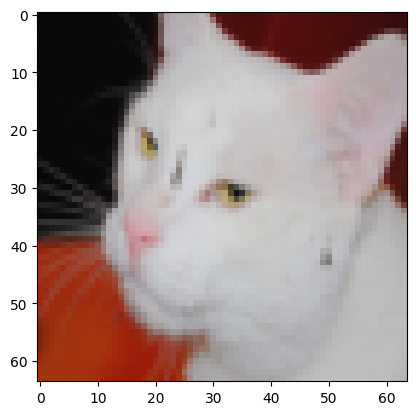

----------------------
----------------------
Predicted: cat
Actual: cat


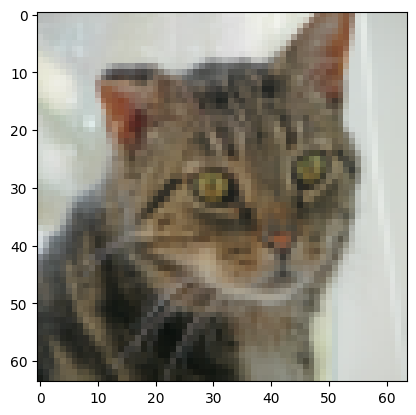

----------------------
----------------------
Predicted: not cat
Actual: not cat


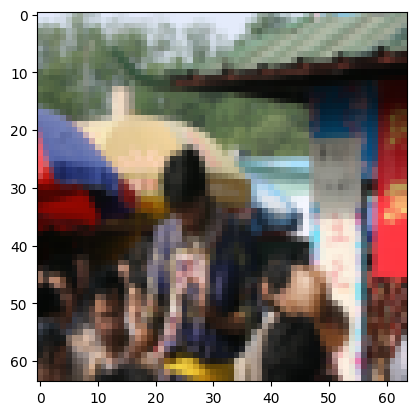

----------------------
----------------------
Predicted: cat
Actual: not cat


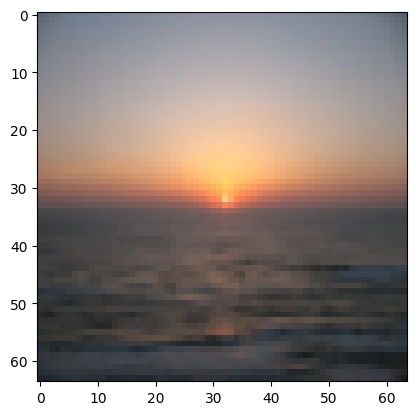

----------------------
----------------------
Predicted: not cat
Actual: not cat


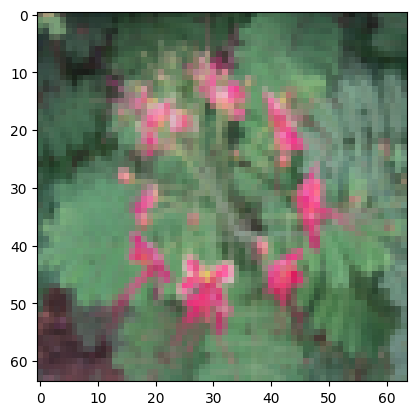

----------------------
----------------------
Predicted: cat
Actual: cat


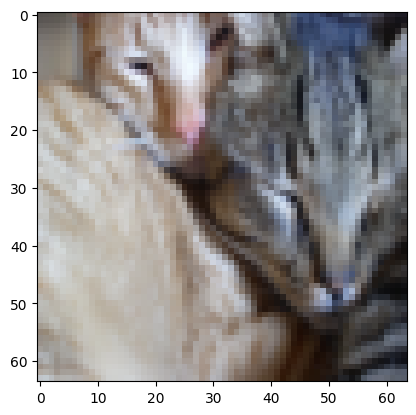

----------------------
----------------------
Predicted: not cat
Actual: not cat


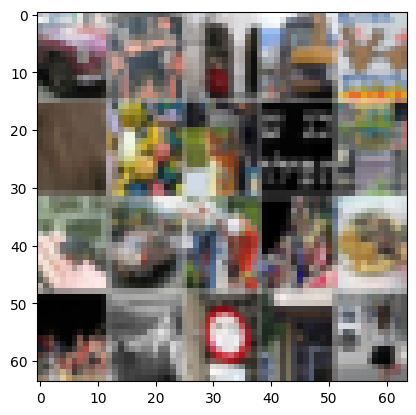

----------------------
----------------------
Predicted: not cat
Actual: not cat


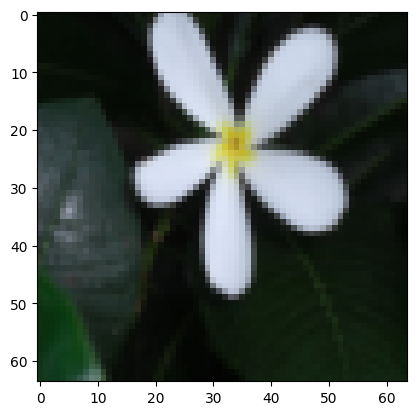

----------------------
----------------------
Predicted: cat
Actual: cat


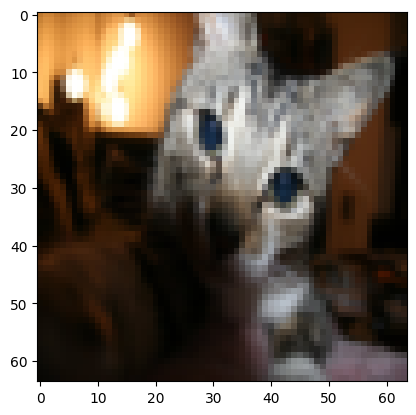

----------------------
----------------------
Predicted: not cat
Actual: cat


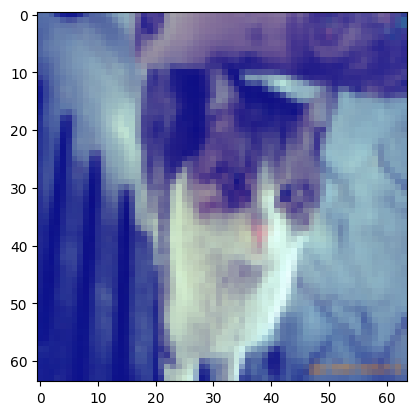

----------------------
----------------------
Predicted: cat
Actual: cat


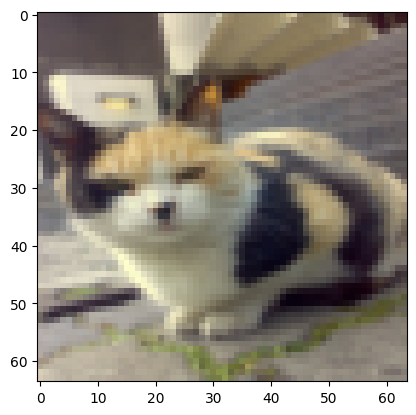

----------------------
----------------------
Predicted: not cat
Actual: not cat


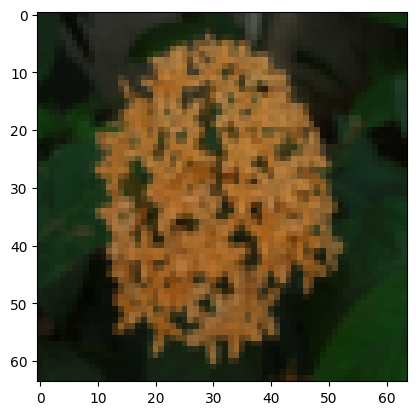

----------------------
----------------------
Predicted: cat
Actual: not cat


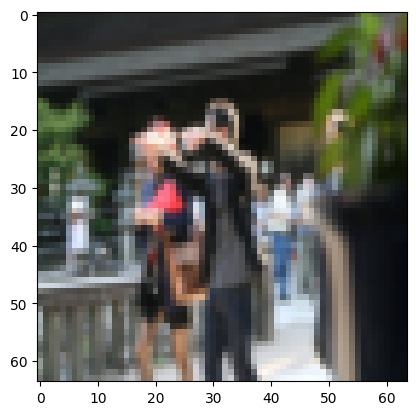

----------------------
----------------------
Predicted: not cat
Actual: not cat


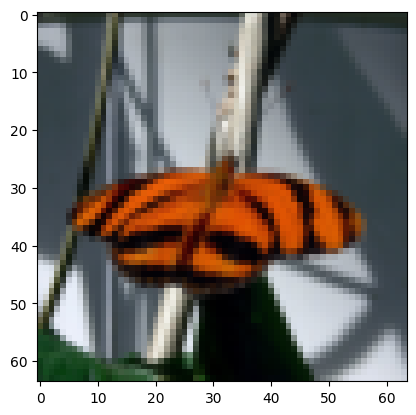

----------------------
----------------------
Predicted: cat
Actual: cat


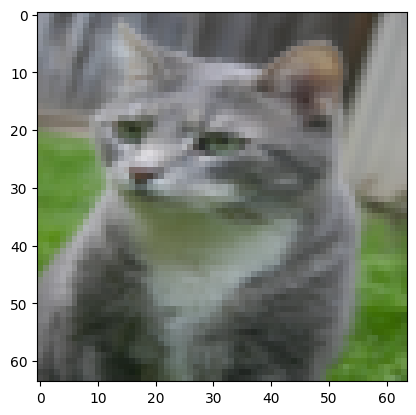

----------------------
----------------------
Predicted: cat
Actual: cat


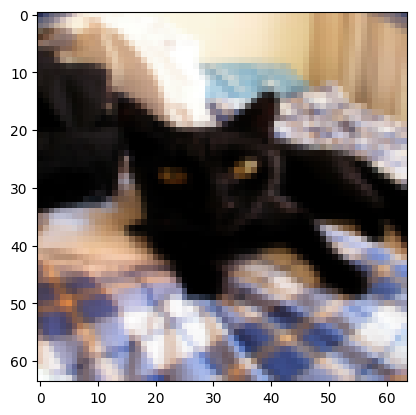

----------------------
----------------------
Predicted: not cat
Actual: cat


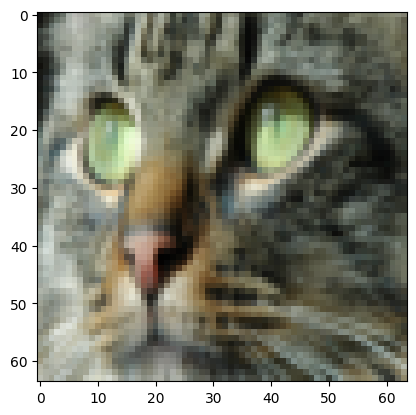

----------------------
----------------------
Predicted: not cat
Actual: not cat


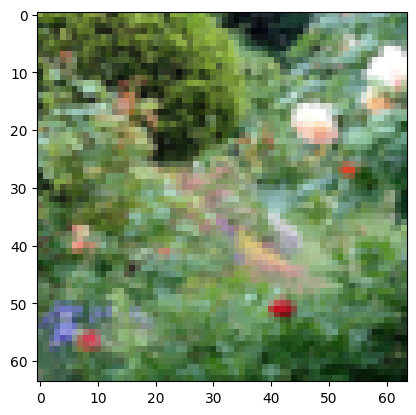

----------------------


In [14]:
for i in range(len(test_images)):
    current = test_images[i]
    prediction = model(current[None].permute(0, 3, 1, 2).cuda()) # None adds a batch dimension of length 1
    prediction = prediction.sigmoid().item() # convert logit to probability and get as float
    prediction = "cat" if prediction > 0.5 else "not cat"
    label = "cat" if test_labels[i] == 1 else "not cat"
    print("----------------------")
    print(f"Predicted: {prediction}")
    print(f"Actual: {label}")
    plt.imshow(current)
    plt.show()
    print("----------------------")

# Model 2: Transfer Learning

Here, you will need to **restart the runtime** in order for things to work properly, since the upcoming model expects a different input distribution than the previous one.

1.   Click Runtime -> Restart Runtime or use the keyboard shortcut ⌘/Ctrl+M if you are in a Colab Notebook, Kernel -> Restart if you are in a Jupyter Notebook, or equivalent actions to restart the runtime.
2.   Run the Loading Data section, but **do not run the input normalization step (i.e. do not divide the images by 255.0)!**

In [15]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

backbone = efficientnet_b3(weights=weights)
backbone.classifier = nn.Identity()

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 216MB/s]


In [16]:
for param in backbone.parameters():
    param.requires_grad = False

In [17]:
model = nn.Sequential(
    backbone,
    nn.Linear(1536, 750),
    nn.ReLU(),
    nn.Linear(750, 1)
)

In [18]:
print("Number of parameters:", sum([x.numel() for x in model.parameters()]))

Number of parameters: 11849733


In [19]:
trainable_params = sum([x.numel() for x in model.parameters() if x.requires_grad])
non_trainable_params = sum([x.numel() for x in model.parameters() if not x.requires_grad])
print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)

Trainable parameters: 1153501
Non-trainable parameters: 10696232


In [20]:
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def evaluate(model, images, labels):
    model.eval() # set model to eval mode to turn off dropout/batchnorm
    with torch.no_grad():
        images, labels = images.cuda(), labels.cuda()
        logits = model(preprocess(images.permute(0, 3, 1, 2)))
        probs = logits.sigmoid()
        preds = (probs > 0.5).float()
        accuracy = (preds.flatten() == labels.flatten()).float().mean().item()
    return accuracy

In [21]:
import tqdm
epochs = 50

training_accuracies, validation_accuracies = [], []
for epoch in range(epochs):
    model.train() # set model to train mode to turn on dropout/batchnorm
    print(f"Epoch {epoch+1}/{epochs}")
    pbar = tqdm.tqdm(train_loader)
    for i, batch in enumerate(pbar):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        logits = model(preprocess(images.permute(0, 3, 1, 2)))
        loss = F.binary_cross_entropy_with_logits(logits.flatten(), labels.flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.4f}")
    train_accuracy = evaluate(model, train_images, train_labels)
    val_accuracy = evaluate(model, test_images, test_labels)
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)
    print(f"Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f}")

Epoch 1/50


Loss: 0.1981: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Train Accuracy: 0.952, Val Accuracy: 1.000
Epoch 2/50


Loss: 0.0433: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Train Accuracy: 0.976, Val Accuracy: 1.000
Epoch 3/50


Loss: 0.8136: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Train Accuracy: 0.995, Val Accuracy: 1.000
Epoch 4/50


Loss: 0.1246: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Train Accuracy: 0.995, Val Accuracy: 1.000
Epoch 5/50


Loss: 0.0027: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Train Accuracy: 0.995, Val Accuracy: 0.960
Epoch 6/50


Loss: 0.0087: 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 7/50


Loss: 0.0099: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 8/50


Loss: 0.0416: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 9/50


Loss: 0.0054: 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 10/50


Loss: 0.0005: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 11/50


Loss: 0.0008: 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 12/50


Loss: 0.0105: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 13/50


Loss: 0.0009: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 14/50


Loss: 0.0041: 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 15/50


Loss: 0.0021: 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 16/50


Loss: 0.0101: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 17/50


Loss: 0.0042: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 18/50


Loss: 0.0010: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 19/50


Loss: 0.0040: 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 20/50


Loss: 0.0007: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 21/50


Loss: 0.0069: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 22/50


Loss: 0.0006: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 23/50


Loss: 0.0083: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 24/50


Loss: 0.0012: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 25/50


Loss: 0.0035: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 26/50


Loss: 0.0012: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 27/50


Loss: 0.0018: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 28/50


Loss: 0.0267: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 29/50


Loss: 0.0004: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 30/50


Loss: 0.0007: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 31/50


Loss: 0.0018: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 32/50


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 33/50


Loss: 0.0002: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 34/50


Loss: 0.0140: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 35/50


Loss: 0.0030: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 36/50


Loss: 0.0244: 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Train Accuracy: 1.000, Val Accuracy: 0.960
Epoch 37/50


Loss: 0.0005: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 38/50


Loss: 0.0002: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 39/50


Loss: 0.0111: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 40/50


Loss: 0.0055: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 41/50


Loss: 0.0007: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 42/50


Loss: 0.0001: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 43/50


Loss: 0.0150: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 44/50


Loss: 0.0002: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 45/50


Loss: 0.0002: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 46/50


Loss: 0.0001: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 47/50


Loss: 0.0868: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 48/50


Loss: 0.0003: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 49/50


Loss: 0.0339: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980
Epoch 50/50


Loss: 0.1801: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Train Accuracy: 1.000, Val Accuracy: 0.980


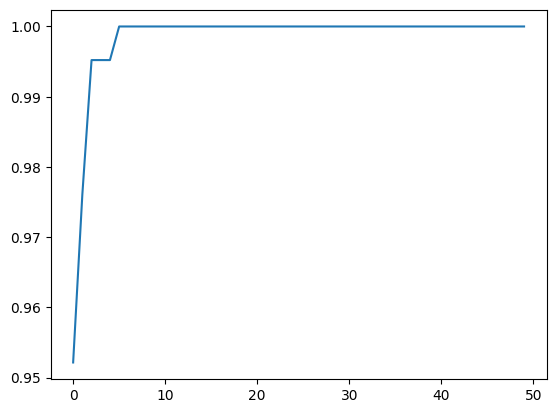

In [22]:
plt.plot(training_accuracies)

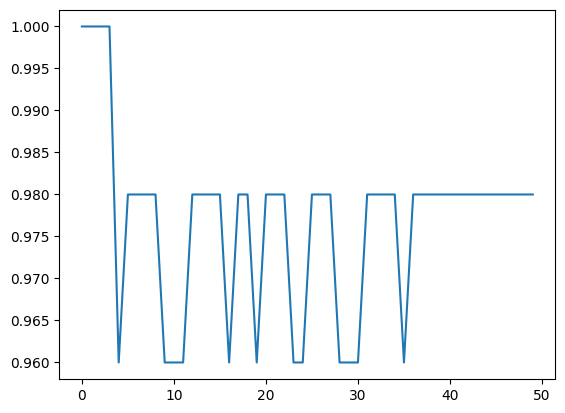

In [23]:
plt.plot(validation_accuracies)